# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [15]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder


In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
#import sys
#sys.path.append(r"D:\CodeTemplate-Regrassion\regression-py\regression-py\src")

In [19]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [20]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [21]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [22]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.1 Read the Train and Test Data

In [301]:
train_X = load_dataset(context, 'train/Data/features')
train_y = load_dataset(context, 'train/Data/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/Data/features')
test_y = load_dataset(context, 'test/Data/target')
print(test_X.shape, test_y.shape)

(2080, 13) (2080, 1)
(634, 13) (634, 1)


## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [302]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [303]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(2080, 13)
(2080, 13)


In [304]:
train_X.head()

,year,month,week,total_post,search_volume,claim_name,D,Private Label,No competition,F,B,H,unit_price
0,2016.0,1.0,1.0,1709.0,42093.0,low carb,1.0,1.0,0.0,0.0,0.0,0.0,4.381675
1,2016.0,1.0,2.0,1849.0,140775.0,low carb,1.0,1.0,0.0,0.0,0.0,0.0,4.340623
2,2016.0,1.0,3.0,2632.0,105801.0,low carb,1.0,1.0,0.0,0.0,0.0,0.0,4.376924
3,2016.0,1.0,4.0,2866.0,117372.0,low carb,1.0,1.0,0.0,0.0,0.0,0.0,4.288565
4,2016.0,2.0,5.0,3345.0,105166.0,low carb,1.0,1.0,0.0,0.0,0.0,0.0,4.255902


In [305]:
for i in range(train_X.shape[0]):
    if train_X['month'][i] in [1,12]:
        train_X.loc[i,'month']='winter'
    elif train_X['month'][i] in [2,3]:
        train_X.loc[i,'month']='spring'
    elif train_X['month'][i] in [4,5,6]:
        train_X.loc[i,'month']='summer'
    elif train_X['month'][i] in [7,8,9]:
        train_X.loc[i,'month']='mansoon'
    else :
        train_X.loc[i,'month']='autumn'
        
        
for i in range(test_X.shape[0]):
    if test_X['month'][i] in [1,12]:
        test_X.loc[i,'month']='winter'
    elif test_X['month'][i] in [2,3]:
        test_X.loc[i,'month']='spring'
    elif test_X['month'][i] in [4,5,6]:
        test_X.loc[i,'month']='summer'
    elif test_X['month'][i] in [7,8,9]:
        test_X.loc[i,'month']='mansoon'
    else :
        test_X.loc[i,'month']='autumn'

In [306]:
train_X.drop(columns=['year','week'],axis=1 , inplace=True)
test_X.drop(columns=['year','week'],axis=1 , inplace=True)
train_X = train_X.rename_column(old_column_name='month',new_column_name='season')
test_X = test_X.rename_column(old_column_name='month',new_column_name='season')

In [307]:
quarter_type_1 = pd.get_dummies(train_X['season'], drop_first=True)
quarter_type_2 = pd.get_dummies(test_X['season'], drop_first=True)
claim_name_1 = pd.get_dummies(train_X['claim_name'], drop_first=True)
claim_name_2 = pd.get_dummies(test_X['claim_name'], drop_first=True)

In [308]:
train_X = pd.concat([train_X, quarter_type_1,claim_name_1] , axis=1)
test_X = pd.concat([test_X, quarter_type_2,claim_name_2] , axis=1)
train_X.drop(columns=['season','claim_name'], axis=1, inplace=True)
test_X.drop(columns=['season','claim_name'], axis=1, inplace=True)

In [309]:
train_X

,total_post,search_volume,D,Private Label,No competition,F,B,H,unit_price,mansoon,...,highsource of protein,low carb,low sodium,low sugar,no additivespreservatives,poultry,salmon,soy foods,tuna,vegetarian
0,1709.0,42093.0,1.0,1.0,0.0,0.0,0.0,0.0,4.381675,0,...,0,1,0,0,0,0,0,0,0,0
1,1849.0,140775.0,1.0,1.0,0.0,0.0,0.0,0.0,4.340623,0,...,0,1,0,0,0,0,0,0,0,0
2,2632.0,105801.0,1.0,1.0,0.0,0.0,0.0,0.0,4.376924,0,...,0,1,0,0,0,0,0,0,0,0
3,2866.0,117372.0,1.0,1.0,0.0,0.0,0.0,0.0,4.288565,0,...,0,1,0,0,0,0,0,0,0,0
4,3345.0,105166.0,1.0,1.0,0.0,0.0,0.0,0.0,4.255902,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,5027.0,160096.0,0.0,0.0,1.0,0.0,0.0,0.0,26.601650,0,...,0,0,0,0,0,0,0,0,0,0
2076,5195.0,146546.0,0.0,0.0,1.0,0.0,0.0,0.0,26.031479,0,...,0,0,0,0,0,0,0,0,0,0
2077,4524.0,170440.0,0.0,0.0,1.0,0.0,0.0,0.0,26.630988,0,...,0,0,0,0,0,0,0,0,0,0
2078,4554.0,79179.0,0.0,0.0,1.0,0.0,0.0,0.0,26.708822,0,...,0,0,0,0,0,0,0,0,0,0


In [310]:
# scaling
from sklearn.preprocessing import PowerTransformer
sc = PowerTransformer()
train_X[['total_post','search_volume','unit_price']] = sc.fit_transform(train_X[['total_post','search_volume','unit_price']])
test_X[['total_post','search_volume','unit_price']] = sc.fit_transform(test_X[['total_post','search_volume','unit_price']])
train_y = sc.fit_transform(pd.DataFrame(train_y))
test_y = sc.fit_transform(pd.DataFrame(test_y))
train_y = pd.DataFrame(train_y)
test_y = pd.DataFrame(test_y)
train_y.rename(columns={0:'sales_dollars_value'}, inplace=True)
test_y.rename(columns={0:'sales_dollars_value'}, inplace=True)

In [311]:
set(train_X.columns) -set(test_X.columns)

{'tuna'}

In [312]:
test_X.drop(columns=['gingerbread','ethical packaging'], axis=1, inplace=True)
train_X.drop(columns=['tuna'], axis=1, inplace=True)

In [313]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [314]:
lin_rig = LinearRegression()
lin_rig.fit(train_X,train_y)
y_pred = lin_rig.predict(test_X)
y_pred
r2_score(test_y,y_pred)

0.9257606590806496

In [315]:
lin_reg = sm.OLS(train_y,sm.add_constant(train_X)).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     sales_dollars_value   R-squared:                       0.985
Model:                             OLS   Adj. R-squared:                  0.984
Method:                  Least Squares   F-statistic:                     5974.
Date:                 Tue, 30 Aug 2022   Prob (F-statistic):               0.00
Time:                         12:42:58   Log-Likelihood:                 1388.2
No. Observations:                 2080   AIC:                            -2730.
Df Residuals:                     2057   BIC:                            -2601.
Df Model:                           22                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5519      0.013    -41.496      0.000      -0.578      -0.526
total_post                    0.0287      0.005      5.707      0.000       0.019       0.039
search_volume                 0.0528      0.011      5.018      0.000       0.032       0.073
D                             0.6392      0.011     59.773      0.000       0.618       0.660
Private Label                 0.2810      0.009     31.282      0.000       0.263       0.299
No competition               -1.3927      0.009   -148.632      0.000      -1.411      -1.374
F                            -0.1612      0.013    -12.373      0.000      -0.187      -0.136
B                             0.0375      0.007      5.400      0.000       0.024       0.051
H                            -0.4582      0.010    -44.078      0.000      -0.479      -0.438
unit_price                    0.0768      0.013      5.779      0.000       0.051       0.103
mansoon                      -0.0194      0.009     -2.227      0.026      -0.036      -0.002
spring                       -0.0306      0.010     -3.160      0.002      -0.050      -0.012
summer                       -0.0249      0.009     -2.841      0.005      -0.042      -0.008
winter                       -0.0187      0.010     -1.936      0.053      -0.038       0.000
blueberry                     0.5414      0.013     42.469      0.000       0.516       0.566
chicken                      -0.7451      0.013    -58.404      0.000      -0.770      -0.720
crab                         -0.0187      0.013     -1.468      0.142      -0.044       0.006
ethnic & exotic               2.5991      0.025    104.217      0.000       2.550       2.648
french bisque                -0.9332      0.012    -74.879      0.000      -0.958      -0.909
gmo free                      0.4108      0.017     23.906      0.000       0.377       0.445
highsource of protein         1.7015      0.025     68.044      0.000       1.652       1.751
low carb                      1.0257      0.012     86.712      0.000       1.003       1.049
low sodium                    0.1801      0.011     17.007      0.000       0.159       0.201
low sugar                     1.3771      0.033     42.145      0.000       1.313       1.441
no additivespreservatives     1.2918      0.017     75.109      0.000       1.258       1.326
poultry                       1.1677      0.028     41.886      0.000       1.113       1.222
salmon                        3.3864      0.017    195.376      0.000       3.352       3.420
soy foods                     3.4397      0.027    126.661      0.000       3.386       3.493
vegetarian                   -0.9119      0.023    -40.371      0.000      -0.956      -0.868
================================================================

In [316]:
import ta_lib.eda.api as eda
import ta_lib.core.api as dataset
import ta_lib.eda.api as ta_analysis

In [317]:
import statsmodels.api as sm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.linear_model import LinearRegression


In [318]:
def performance(X_train,y_train, X_test,y_test):
    lin_reg = sm.OLS(y_train,sm.add_constant(X_train)).fit()
    y_train_pred =  lin_reg.predict(sm.add_constant(X_train))
    y_test_pred =  lin_reg.predict(sm.add_constant(X_test))
    print('Linear Regression Model')
    print('-'*50)
    print('Train R2',r2_score(y_train,y_train_pred))
    print('Test R2',r2_score(y_test,y_test_pred))
    print('-'*50)
    print('Train MAPE:', mean_absolute_percentage_error(y_train,y_train_pred))
    print('Test MAPE:', mean_absolute_percentage_error(y_test,y_test_pred))
    print('Cross Val Score of MAPE:')
    scores = -1*cross_val_score(LinearRegression(),X_train,y_train,cv=5,
                scoring='neg_mean_absolute_percentage_error')
    bias  = np.mean(scores)
    variance = np.std(scores,ddof=1)
    print('CV_scores:',scores)
    print('Bias :',bias)
    print('Variance:',variance)
performance(train_X,train_y,test_X,test_y)

Linear Regression Model
--------------------------------------------------
Train R2 0.9845893527585499
Test R2 0.9283565244096187
--------------------------------------------------
Train MAPE: 0.17608959392166523
Test MAPE: 6.4195608655544705
Cross Val Score of MAPE:
CV_scores: [2.33993989 1.07941894 1.14089383 1.91901406 2.21494121]
Bias : 1.7388415868188265
Variance: 0.594313026026358


In [319]:
from sklearn.ensemble import RandomForestRegressor

def performance(X_train,y_train, X_test,y_test):
    rand_for = RandomForestRegressor(n_estimators = 10, random_state = 0)
    rand_for.fit(X_train, y_train)
    y_train_pred =  rand_for.predict(X_train)
    y_test_pred =  rand_for.predict(X_test)
    print('Random Forest Regression Model')
    print('-'*50)
    print('Train R2',r2_score(y_train,y_train_pred))
    print('Test R2',r2_score(y_test,y_test_pred))
    print('-'*50)
    print('Train MAPE:', mean_absolute_percentage_error(y_train,y_train_pred))
    print('Test MAPE:', mean_absolute_percentage_error(y_test,y_test_pred))
    print('Cross Val Score of MAPE:')
    scores = -1*cross_val_score(RandomForestRegressor(),X_train,y_train,cv=5,
                scoring='neg_mean_absolute_percentage_error')
    bias  = np.mean(scores)
    variance = np.std(scores,ddof=1)
    print('CV_scores:',scores)
    print('Bias :',bias)
    print('Variance:',variance)
performance(train_X,train_y,test_X,test_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest Regression Model
--------------------------------------------------
Train R2 0.9985742571838314
Test R2 0.8877762503203172
--------------------------------------------------
Train MAPE: 0.033550843164378966
Test MAPE: 8.625263381068214
Cross Val Score of MAPE:


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CV_scores: [1.58572693 1.20824579 1.54339553 1.41465192 1.4026987 ]
Bias : 1.4309437748175688
Variance: 0.14769971601007595


In [320]:
rand_for = RandomForestRegressor()
rand_for.fit(train_X,train_y)
y_pred = rand_for.predict(test_X)
y_pred
r2_score(test_y,y_pred)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.8892492284981648

In [321]:
y_pred = pd.DataFrame(y_pred)
y_pred.rename(columns={0:'sales_dollars_value'}, inplace=True)
y_pred

,sales_dollars_value
0,1.398609
1,1.404474
2,1.403922
3,1.404270
4,1.404845
...,...
629,0.862796
630,0.832909
631,0.838625
632,0.839749


In [322]:
test_y = sc.inverse_transform(test_y)
y_pred = sc.inverse_transform(y_pred)

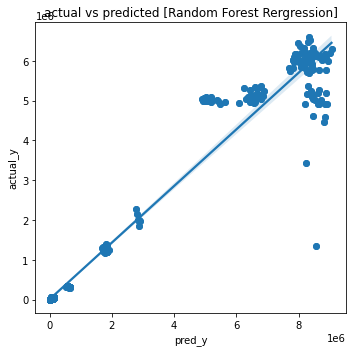

In [323]:
%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(test_y, y_pred)
sns.regplot(test_y,y_pred)

plt.xlabel('pred_y')
plt.ylabel('actual_y')
plt.title('actual vs predicted [Random Forest Rergression]')
plt.savefig('fig-9.png')


In [324]:
from sklearn.tree import DecisionTreeRegressor 

def performance(X_train,y_train, X_test,y_test):
    des_tree = DecisionTreeRegressor(random_state = 0)
    des_tree.fit(X_train, y_train)
    y_train_pred =  des_tree.predict(X_train)
    y_test_pred =  des_tree.predict(X_test)
    print('Random Forest Regression Model')
    print('-'*50)
    print('Train R2',r2_score(y_train,y_train_pred))
    print('Test R2',r2_score(y_test,y_test_pred))
    print('-'*50)
    print('Train MAPE:', mean_absolute_percentage_error(y_train,y_train_pred))
    print('Test MAPE:', mean_absolute_percentage_error(y_test,y_test_pred))
    print('Cross Val Score of MAPE:')
    scores = -1*cross_val_score(DecisionTreeRegressor(),X_train,y_train,cv=5,
                scoring='neg_mean_absolute_percentage_error')
    bias  = np.mean(scores)
    variance = np.std(scores,ddof=1)
    print('CV_scores:',scores)
    print('Bias :',bias)
    print('Variance:',variance)
performance(train_X,train_y,test_X,test_y)

Random Forest Regression Model
--------------------------------------------------
Train R2 1.0
Test R2 -0.30841563195483945
--------------------------------------------------
Train MAPE: 1.7206407025921793e-19
Test MAPE: 1.0012047992320248
Cross Val Score of MAPE:
CV_scores: [1.93585566 3.78685598 1.32393042 1.4248099  1.0867836 ]
Bias : 1.9116471128286883
Variance: 1.0931394606097138


In [263]:
out = eda.get_target_correlation(train_X, train_y)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

In [264]:
back_ele_features = train_X.columns.tolist()
while(len(back_ele_features)>0):
    features_with_constant = sm.add_constant(train_X[back_ele_features])
    p_values = sm.OLS(train_y, features_with_constant).fit().pvalues[1:]
    max_p_value = p_values.max()
    if(max_p_value >= 0.05):
        excluded_feature = p_values.idxmax()
        back_ele_features.remove(excluded_feature)
    else:
        break 
print(back_ele_features)

['total_post', 'search_volume', 'D', 'Private Label', 'No competition', 'F', 'B', 'H', 'unit_price', 'blueberry', 'chicken', 'ethnic & exotic', 'french bisque', 'gmo free', 'highsource of protein', 'low carb', 'low sodium', 'low sugar', 'no additivespreservatives', 'poultry', 'salmon', 'soy foods', 'vegetarian']


In [265]:
lin_reg_be = sm.OLS(train_y,sm.add_constant(train_X[back_ele_features])).fit()
lin_reg_be.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     sales_dollars_value   R-squared:                       0.985
Model:                             OLS   Adj. R-squared:                  0.984
Method:                  Least Squares   F-statistic:                     7273.
Date:                 Tue, 30 Aug 2022   Prob (F-statistic):               0.00
Time:                         11:50:26   Log-Likelihood:                 1382.3
No. Observations:                 2080   AIC:                            -2727.
Df Residuals:                     2061   BIC:                            -2619.
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5707      0.014    -41.523      0.000      -0.598      -0.544
total_post                    0.0272      0.005      5.476      0.000       0.017       0.037
search_volume                 0.0549      0.010      5.284      0.000       0.035       0.075
D                             0.6463      0.014     45.772      0.000       0.619       0.674
Private Label                 0.2727      0.008     35.323      0.000       0.258       0.288
No competition               -1.3949      0.009   -151.477      0.000      -1.413      -1.377
F                            -0.1722      0.018     -9.798      0.000      -0.207      -0.138
B                             0.0444      0.011      4.026      0.000       0.023       0.066
H                            -0.4493      0.013    -34.194      0.000      -0.475      -0.424
unit_price                    0.0787      0.013      5.919      0.000       0.053       0.105
blueberry                     0.5459      0.012     44.404      0.000       0.522       0.570
chicken                      -0.7471      0.013    -58.900      0.000      -0.772      -0.722
ethnic & exotic               2.5975      0.025    104.620      0.000       2.549       2.646
french bisque                -0.9250      0.015    -63.189      0.000      -0.954      -0.896
gmo free                      0.4179      0.019     21.988      0.000       0.381       0.455
highsource of protein         1.7047      0.025     68.412      0.000       1.656       1.754
low carb                      1.0277      0.012     84.642      0.000       1.004       1.051
low sodium                    0.1699      0.012     14.730      0.000       0.147       0.193
low sugar                     1.3801      0.033     42.219      0.000       1.316       1.444
no additivespreservatives     1.2908      0.017     75.840      0.000       1.257       1.324
poultry                       1.1695      0.028     42.168      0.000       1.115       1.224
salmon                        3.3894      0.017    195.705      0.000       3.355       3.423
soy foods                     3.4432      0.027    126.795      0.000       3.390       3.496
vegetarian                   -0.9092      0.023    -40.293      0.000      -0.953      -0.865
==============================================================================
Omnibus:                      450.928   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2921.140
Skew:                          -0.858   Prob(JB):                         0.00
Kurtosis:                       8.546   Cond. No.                     3.06e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matri

In [266]:
performance(train_X[back_ele_features],train_y,test_X[back_ele_features],test_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest Regression Model
--------------------------------------------------
Train R2 0.9984740105165862
Test R2 -0.3084156327358307
--------------------------------------------------
Train MAPE: 0.03807952788596517
Test MAPE: 1.0010696592285304
Cross Val Score of MAPE:


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CV_scores: [1.53849229 1.12988269 1.56409968 1.46095333 1.38860165]
Bias : 1.416405928904013
Variance: 0.17433562348698173


Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels.
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

**Dev notes(Encoding):**
<details>

    Some common practices followed in Categorical Feature Encoding are
    * For categorical variables with too many levels, target encoding can be done.
    * For fewer levels, one hot encoding can be done.
    * If one very dominant level is observed, binary encoding can be used.
    
    
</details>

## 3.2 Feature analysis

Using the pipeline above analyze the features and decide on additional features to add/remove from the pipeline. This section will not be part of the production code, unless input data drifts etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


- we create some sample data to analyze that we assume represent the population
- train the features transformer and do the analysis as below

Running the features transformer on the complete data

In [ ]:
out = eda.get_density_plots(train_X, cols=['brand', 'condition'])
out

In [ ]:
# save the plots are html
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

A report containing the above plot is available [here](https://drive.google.com/file/d/16ntqUc_zvpg0at5pTtO-ljBjw5UVGFnp/view?usp=sharing)


Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1vUaCcs1PJ4IYo1em9-eZIEj9WuDsnFKT/view?usp=sharing)

In [ ]:
reports.feature_analysis(train_X,'./feature_analysis_report.html')

### 3.2.2 Bivariate - mutual interactions

- Find columns with high correlations and drop them

In [ ]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

In [ ]:
# channel and source_channel highly correlated. So discarding source_channel
# brand and manufacturer are almost same so discarding manufacturer.
# Similarly keeping sku between inventory and sku
# Similarly keeping condition between conditions and ext_grade
# Similarly keeping model_family between platforms, ext_model_family and model_family
# Discarding selling price & selling cost as they are multiples of unit price/cost & quantity.
# Discarding gp as it is the of selling price and selling cost
# order_no, line, invoice_no & customername cannot be IDVs
curated_columns = list(
    set(train_X.columns.to_list()) 
    - set(['manufacturer', 'inventory_id', 'ext_grade', 'source_channel',
           'tgt_enc_iter_impt_platforms', 'ext_model_family',
           'order_no', 'line', 'inventory_id',
           'gp', 'selling_price', 'selling_cost','invoice_no','customername'])
)

train_X = train_X[curated_columns]

out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

In [ ]:
out = eda.get_bivariate_plots(train_X, x_cols=['brand'], y_cols=['color'])
out

In [ ]:
%%time
# create reports as needed
cols = train_X.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(train_X, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='feature_analysis_bivariate')

A report containing the bivariate plot is available [here](https://drive.google.com/file/d/1WSGT3586tY-rOmZ57xGILbmL5ll9cSVT/view?usp=sharing)

Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1A2fz_bjYv8I3iaFDT75JQSDKeJEXxCtp/view?usp=sharing)

In [ ]:
reports.feature_interactions(train_X,'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

In [ ]:
out = eda.get_target_correlation(train_X, train_y)
display_as_tabs([(k, v) for k,v in out.items()])

In [ ]:
train_y['unit_price']

In [ ]:
out = eda.get_feature_importances(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Key drivers report like feature importance, bivariate plots can be obtained as below

In [ ]:
reports.key_drivers(train_X,train_y, './key_drivers_report.html', y_continuous=True)

**Dev Notes**
<details>
    
- The SHAP plots and bivariate plots in key drivers reports can be obtained by including quick=False as a parameter to key_drivers function call. 
- SHAP plots and bivariate plots often take long depending on data shape.
- The plot with shap is present [here](https://drive.google.com/file/d/1JOTMBLiv3LEqZ-kxZz0RokW9v5UyiGva/view?usp=sharing)

</details>


All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below. The output from this is available [here](https://drive.google.com/file/d/1209MzmSSEhiTYuPfHpaVXFXUVbkaJm0B/view?usp=sharing)

In [ ]:
reports.data_exploration(train_X,train_y,'./data_exploration_report.html', y_continuous=True)

In [ ]:
# saving the list of relevant columns
save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# save the feature pipeline
save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features.joblib')))

# 4 Modelling

## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [ ]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [ ]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

### 4.1.2 Data transformations

In [ ]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [ ]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


In [ ]:
reg_ppln_ols['estimator'].summary()

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [ ]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])

test_X = get_dataframe(
    features_transformer.transform(test_X), 
    get_feature_names_from_column_transformer(features_transformer)
)
test_X = test_X[curated_columns]

In [ ]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/18RlQTsT1ze09Cgz-qpb4ha_cvyWbN5F5/view?usp=sharing).
</details>

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [ ]:
threshold=0.3
residual_analysis = test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [ ]:
residual_analysis.hvplot.kde(y="unit_cost",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="unit_cost",
                                title=f'unit cost(density)',legend='top_right')

- From the above plot we can infer that the higher "over predictions" are happening for unit_cost > 200.
- similarly, the higher "under predictions" are happening for unit_cost is zero.

This can help us tune the model by a separate model for unit_cost > 200


# 4.2 Modelling - XGBoost

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.2.2 Model Pipeline Build

In [ ]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(train_X, train_y)

### 4.2.3 Model Tuning

In [ ]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

'condition','model_family','days_since_last_purchase','first_time_customer','sales_person', are considered to be important and in grid search

##### Pipeline build based on new importance features

In [ ]:
# let's find features for some decent defaults
imp_features = ['model_family','sku','unit_cost','condition','brand','business_unit']

estimator = XGBRegressor()
xgb_training_pipe2 = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', XGBRegressor())
])

#### Grid Search of the Estimator

In [ ]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500], 
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

#### Pipeline Build using the best estimator

In [ ]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(train_X, train_y)

In [ ]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y)
reg_tree_report.get_report(include_shap=False, file_path='regression_tree_model_report')

The Regression report containing the feature importances are available [here](https://drive.google.com/file/d/1JBfL3uxPcxBfl0amweXBFmLr7CSHFBUO/view?usp=sharing)

# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [ ]:
model_pipelines = [reg_ppln, xgb_pipeline_final]
model_comparison_report = RegressionComparison(models=model_pipelines,x=train_X, y=train_y)
metrics = model_comparison_report.get_report(file_path='regression_comparison')

In [ ]:
model_comparison_report.performance_metrics

A report comparing the performance, metrics between Linear model and Tree model are available [here](https://drive.google.com/file/d/1LDibiFap9K4DKME-Y0S0mtI_05lTdaJF/view?usp=sharing)

**Dev NOTES**
<details>

the above metrics are absolute nos and not %ges

In this example we are choosing LM model for pipelining. General criteria for choosing production models is:

- Parametric models (aka whitebox models) such as Linear Regression are easier to explain to non-technical audience.
- Generally these are accepted fast and adoption is quicker.
- If the downstream calls for optimization using these models parametric models are easier to implement.
- When accuracy is primary goal without explainability, the above two takes a backseat